In [220]:
%matplotlib inline
import xarray as xr 
import pandas as pd
import numpy as np
import glob
import pyart
from datetime import datetime
from datetime import timezone



from operator import itemgetter
from itertools import groupby

test_file_path = '/Volumes/hard_lacie_hfs/data/indian_radar_data/'

from inrad_reader import inrad_to_cf

In [31]:
def get_sweep_num_from_filename(filename):
    parts = filename.split('sweep')
    return int(parts[1].split('.nc')[0])
    
def get_sorted_list(filename_list_glob):
    pass
    filename_list = glob.glob(test_file_path + 'T_HAHA00_C_DEMS_20180701080230*.nc')
    filename_list.sort(key=get_sweep_num_from_filename)
    return filename_list



In [217]:
dset

<xarray.Dataset>
Dimensions:           (bin: 831, radial: 3600, sweep: 10)
Dimensions without coordinates: bin, radial, sweep
Data variables:
    siteLat           float32 28.58975
    siteLon           float32 77.22195
    siteAlt           float32 253.0
    firstGateRange    float32 600.0
    gateSize          float32 300.0
    nyquist           float32 23.985
    unambigRange      float32 249.82709
    calibConst        float32 -39.5625
    radarConst        float32 66.91
    beamWidthHori     float32 0.95000005
    pulseWidth        float32 1.0
    bandWidth         float32 1180.0
    filterDop         int16 2
    elevationList     (sweep) float32 0.49987793 0.99975586 1.9995117 ...
    azimuthSpeed      float32 10.178833
    highPRF           float32 600.0
    lowPRF            float32 450.0
    dwellTime         float32 98.24309
    waveLength        float32 5.33
    calI0             float32 -109.57
    calNoise          float32 -75.91
    groundHeight      float32 217.0
    mel

In [202]:
SCAN_TYPE_MAPPING ={
    0: 'other',
    1: 'sector',
    2: 'rhi',
    4: 'ppi',
    7: 'rhi'
}

MOMENT_NAME_MAPPING ={ 
    'T': 'total_power',
    'Z': 'reflectivity',
    'V': 'mean_doppler_velocity',
    'W': 'spectrum_width',
    'ZDR' : 'differential_reflectivity',
    'KDP' : "specific_differential_phase",
    "PHIDP": "differential_phase",
    "SQI": "normalized_coherent_power",
    "RHOHV": "copol_correlation_coeff",
    "HCLASS": "hydrometeor_classification"
}


In [212]:
_range =  {'data': np.arange(0, dset.dims['bin']) * dset['gateSize'].values + dset['firstGateRange'].values}
fixed_angle = list(map(itemgetter(0), groupby(dset['elevationAngle'].values)))
num_rays_per_sweep = [np.count_nonzero(np.isclose(dset['elevationAngle'].values, val)) for val in fixed_angle]
sweep_start_ray_index = {'data': np.hstack((0, np.cumsum(num_rays_per_sweep)[0:-1]))}
sweep_end_ray_index = {'data': ( np.cumsum(num_rays_per_sweep)-1)}
time = {'data': dset['radialTime'],
       'units': 'seconds since 1970-1-1 00:00:00.00'}
fields = {}


for moment_name in MOMENT_NAME_MAPPING:
    fields[MOMENT_NAME_MAPPING[moment_name]] = {
        'data': dset[moment_name].values,
        'units': dset[moment_name].units,
        'long_name': dset[moment_name].long_name
    }
sweep_mode = []
for i in np.arange(dset.dims['sweep']):
    sweep_mode.append('manual_'+SCAN_TYPE_MAPPING[int(dset['scanType'].values)])

radar = pyart.core.Radar(time=time, _range=_range, azimuth={'data': dset['radialAzim'].values}, elevation={'data': dset['radialElev'].values},
                         fixed_angle={'data': fixed_angle}, sweep_start_ray_index = sweep_start_ray_index, sweep_end_ray_index = sweep_end_ray_index,
                        longitude={'data': dset['siteLon'].values}, latitude={'data': dset['siteLat'].values}, altitude={'data': dset['siteAlt'].values},
                        scan_type=SCAN_TYPE_MAPPING[int(dset['scanType'].values)], sweep_number={'data': np.arange(0,dset.dims['sweep'])},
                         fields=fields, metadata={}, sweep_mode=sweep_mode
                        )

In [213]:
display = pyart.graph.RadarDisplay(radar)

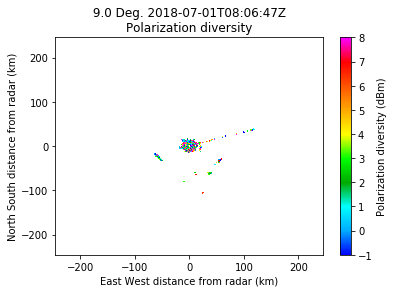

In [216]:
display.plot('differential_reflectivity',6)

In [222]:
radar = inrad_to_cf.read_multi_radar(test_file_path + 'T_HAHA00_C_DEMS_20180701080230*.nc')

In [224]:
radar.fields.keys()

dict_keys(['total_power', 'reflectivity', 'mean_doppler_velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'differential_phase', 'normalized_coherent_power', 'copol_correlation_coeff', 'hydrometeor_classification'])